In [87]:
import os, sys
import pathlib
sys.path.append(os.path.join(pathlib.Path().absolute(), '../src/predictor'))
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from math import sqrt
from catboost import CatBoostRegressor
from joblib import dump
from sklearn.metrics import r2_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import preprocessing
from utils import DateTransformer
from utils import MultiColumnLabelEncoder
from utils import ColumnSelector
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from IPython.display import display

In [88]:
pd.set_option('display.max_rows', 1000)

In [89]:
df = pd.read_csv('/Users/ioneuk/Documents/flight-price-predictor/data/processed_dataset2.csv', parse_dates=['date_time', 'departure_date_time', 'arrival_date_time'])

In [90]:
df.dtypes

date_time                datetime64[ns]
departure_city                   object
departure_iata_code              object
arrival_city                     object
destination_iata_code            object
departure_date_time      datetime64[ns]
arrival_date_time        datetime64[ns]
flight_duration                   int64
carrier_name                     object
agent_name                       object
flight_number                     int64
price                           float64
prev_price_1                      int64
prev_price_2                      int64
prev_price_3                      int64
dtype: object

In [91]:
df.shape

(8258, 15)

In [92]:
df.head()

,date_time,departure_city,departure_iata_code,arrival_city,destination_iata_code,departure_date_time,arrival_date_time,flight_duration,carrier_name,agent_name,flight_number,price,prev_price_1,prev_price_2,prev_price_3
0,2020-02-03 05:26:15.387024,Kiev,IEV,Vienna,VIE,2020-03-14 13:10:00,2020-03-14 14:10:00,120,Wizz Air,Wizz Air,6127,975.05,0,0,0
1,2020-02-03 18:15:23.872834,Sofia,SOF,Budapest,BUD,2020-03-05 13:00:00,2020-03-05 13:25:00,85,Wizz Air,Wizz Air,2472,409.49,0,0,0
2,2020-02-03 11:01:54.768565,Berlin,SXF,Geneva,GVA,2020-03-14 17:00:00,2020-03-14 18:45:00,105,easyJet,easyJet,1596,623.10,0,0,0
3,2020-02-03 11:01:54.768565,Berlin,SXF,Geneva,GVA,2020-03-14 06:10:00,2020-03-14 08:00:00,110,easyJet,easyJet,1592,623.10,0,0,0
4,2020-02-03 11:01:54.768565,Berlin,TXL,Zurich,ZRH,2020-03-05 14:10:00,2020-03-05 15:40:00,90,easyJet,easyJet,5867,623.10,0,0,0


In [93]:
df.columns

Index(['date_time', 'departure_city', 'departure_iata_code', 'arrival_city',
       'destination_iata_code', 'departure_date_time', 'arrival_date_time',
       'flight_duration', 'carrier_name', 'agent_name', 'flight_number',
       'price', 'prev_price_1', 'prev_price_2', 'prev_price_3'],
      dtype='object')

In [94]:
tscv = TimeSeriesSplit(n_splits=3)

In [95]:
df.dtypes

date_time                datetime64[ns]
departure_city                   object
departure_iata_code              object
arrival_city                     object
destination_iata_code            object
departure_date_time      datetime64[ns]
arrival_date_time        datetime64[ns]
flight_duration                   int64
carrier_name                     object
agent_name                       object
flight_number                     int64
price                           float64
prev_price_1                      int64
prev_price_2                      int64
prev_price_3                      int64
dtype: object

In [96]:
all_features = df.columns

In [97]:
categorical_features = ['departure_city','arrival_city', 'carrier_name']

In [98]:
all_columns_to_use = ['departure_city','arrival_city', 'flight_duration', 'carrier_name', 'flight_number', 'departure_hour', 'departure_minute', 'arrival_hour', 'arrival_minute', 'days_left_to_departure', 'is_holiday', 'prev_price_1', 'prev_price_2', 'prev_price_3']

In [99]:
def rmse(real, predicted):
    return sqrt(mean_squared_error(real, predicted))

In [100]:
parameters = {
    "loss_function": "RMSE",
    "eval_metric": "R2",
    "iterations": 1000,
    "learning_rate": 0.03,
    "random_seed": 42,
    "od_wait": 30,
    "od_type": "Iter",
    "thread_count": 10,
    "silent": True,
    "cat_features": categorical_features
}

In [101]:
# grid_search_params = {
#     'price_regressor__learning_rate': [0.03],
# #      'depth': [4, 6, 8, 10],
#      'price_regressor__iterations': [500]
# }

In [102]:
price_regressor = CatBoostRegressor(**parameters)

In [103]:
class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        print(X.columns)
        print()
        print(X.dtypes)
        return self

    def transform(self, df, y=None):
        return df

In [104]:
pipeline = Pipeline( steps = [
    ('date_transformer', DateTransformer()),
    ('label_encoder', MultiColumnLabelEncoder(columns = categorical_features)),
#     ('shift_transformer_1', ShiftTransformer('price', 'prev_price_1', 'int', ['departure_date', 'arrival_date', 'departure_city','arrival_city','flight_number','carrier_name'], 1, 'date_time')),
    ('column_selector', ColumnSelector(all_columns_to_use)),
#     ('debug', DebugTransformer()),
    ('price_regressor', price_regressor)])

In [105]:
pipeline.predict

<function sklearn.pipeline.Pipeline.predict(self, X, **predict_params)>

In [106]:
df.head()

,date_time,departure_city,departure_iata_code,arrival_city,destination_iata_code,departure_date_time,arrival_date_time,flight_duration,carrier_name,agent_name,flight_number,price,prev_price_1,prev_price_2,prev_price_3
0,2020-02-03 05:26:15.387024,Kiev,IEV,Vienna,VIE,2020-03-14 13:10:00,2020-03-14 14:10:00,120,Wizz Air,Wizz Air,6127,975.05,0,0,0
1,2020-02-03 18:15:23.872834,Sofia,SOF,Budapest,BUD,2020-03-05 13:00:00,2020-03-05 13:25:00,85,Wizz Air,Wizz Air,2472,409.49,0,0,0
2,2020-02-03 11:01:54.768565,Berlin,SXF,Geneva,GVA,2020-03-14 17:00:00,2020-03-14 18:45:00,105,easyJet,easyJet,1596,623.10,0,0,0
3,2020-02-03 11:01:54.768565,Berlin,SXF,Geneva,GVA,2020-03-14 06:10:00,2020-03-14 08:00:00,110,easyJet,easyJet,1592,623.10,0,0,0
4,2020-02-03 11:01:54.768565,Berlin,TXL,Zurich,ZRH,2020-03-05 14:10:00,2020-03-05 15:40:00,90,easyJet,easyJet,5867,623.10,0,0,0


In [107]:
cv_rmse = []
cv_mae = []
cv_r2 = []
for idx, split_idx_tuple in enumerate(tscv.split(df)):
    x_train_idx, x_test_idx = split_idx_tuple[0], split_idx_tuple[1]
    pipeline.fit(df.iloc[x_train_idx], df.loc[x_train_idx, 'price'])
    prediction = pipeline.predict(df.iloc[x_test_idx])
    current_rmse = rmse(prediction, df.loc[x_test_idx, 'price'])
    cv_rmse.append(current_rmse)
    current_mae = mean_absolute_error(df.loc[x_test_idx, 'price'], prediction)
    cv_mae.append(current_mae)
    current_r2 = r2_score(df.loc[x_test_idx, 'price'], prediction)
    cv_r2.append(current_r2)
    print("RMSE on {}th fold: {}".format(idx, current_rmse))
    print("MAE on {}th fold: {}".format(idx, current_mae))
    print("R2 on {}th fold: {}".format(idx, current_r2))

mean_rmse = sum(cv_rmse) / len(cv_rmse)
mean_mae = sum(cv_mae) / len(cv_mae)
mean_r2 = sum(cv_r2) / len(cv_r2)
print("mean rmse: {}".format(mean_rmse))
print("mean mae: {}".format(mean_mae))
print("mean r2: {}".format(mean_r2))

/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RMSE on 0th fold: 319.50193340943645
MAE on 0th fold: 210.74060756597117
R2 on 0th fold: 0.863097117867047


/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RMSE on 1th fold: 360.85828456221947
MAE on 1th fold: 227.02289468072067
R2 on 1th fold: 0.8261361992416689


/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/ioneuk/opt/anaconda3/envs/scrapper/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


RMSE on 2th fold: 607.4535957496063
MAE on 2th fold: 305.32899880476225
R2 on 2th fold: 0.6442648361628691
mean rmse: 429.27127124042073
mean mae: 247.6975003504847
mean r2: 0.7778327177571951


In [108]:
feature_importances = price_regressor.get_feature_importance()

In [109]:
feature_importances

array([ 6.68514865,  4.06865802,  3.02439942, 13.84528592,  2.14351346,
        1.33941553,  0.98380744,  1.21724188,  1.52715418,  2.98260057,
        0.34248768, 54.15777746,  5.09866001,  2.58384977])

In [110]:
len(feature_importances)

14

In [111]:
feature_names = ['departure_city', 'arrival_city', 'flight_duration','carrier_name','flight_number','departure_hour','departure_minute','arrival_hour','arrival_minute','days_left_to_departure','is_holiday','prev_price_1','prev_price_2','prev_price_3']

In [112]:
len(feature_names)

14

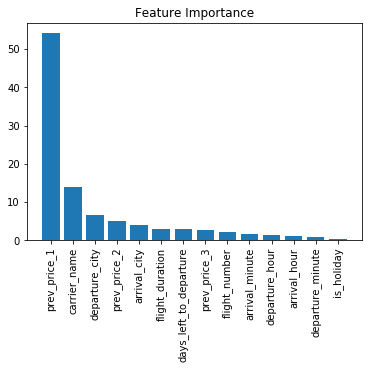

In [113]:
indices = np.argsort(feature_importances)[::-1]
names = [feature_names[i] for i in indices]
plt.figure()
plt.title("Feature Importance")
plt.bar(range(len(feature_importances)), feature_importances[indices])
plt.xticks(range(len(feature_importances)), names, rotation=90)

plt.show()

In [114]:
pipeline.fit(df, df.loc[:, 'price'])

Pipeline(memory=None,
         steps=[('date_transformer', DateTransformer()),
                ('label_encoder',
                 MultiColumnLabelEncoder(columns=['departure_city',
                                                  'arrival_city',
                                                  'carrier_name'])),
                ('column_selector',
                 ColumnSelector(columns=['departure_city', 'arrival_city',
                                         'flight_duration', 'carrier_name',
                                         'flight_number', 'departure_hour',
                                         'departure_minute', 'arrival_hour',
                                         'arrival_minute',
                                         'days_left_to_departure', 'is_holiday',
                                         'prev_price_1', 'prev_price_2',
                                         'prev_price_3'])),
                ('price_regressor',
                 <catboost.core.Cat

In [115]:
# grid_search = GridSearchCV(pipeline, param_grid = grid_search_params, cv = tscv, scoring = rmse_scorer)

In [116]:
# df["flight_number"] = df["flight_number"].astype(str)
# df["departure_date_time"] = df["departure_date_time"].astype(str)
# df["arrival_date_time"] = df["arrival_date_time"].astype(str)
# df["date_time"] = df["date_time"].astype(str)

In [117]:
# grid_search.fit(df, df['price'])

In [118]:
# grid_search.best_score_

In [119]:
# print("\n========================================================")
# print(" Results from Random Search " )
# print("========================================================")    
# print("\n The best estimator across ALL searched params:\n",
# grid_search.best_estimator_)
# print("\n The best score across ALL searched params:\n",grid_search.best_score_)
# print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)
# print("\n ========================================================")

In [120]:
dump(price_regressor, "model.pkl")

['model.pkl']